#   NN for Handwritten Digit Classification

*   Imports


In [425]:
from sklearn.datasets import load_digits
import pandas as pd
from matplotlib import pyplot as plt
from numpy import ndarray
import numpy as np
from typing import Callable, List
from sklearn.model_selection import train_test_split

In [501]:
dataset = load_digits()
dataset_len = len(dataset["data"])

In [ ]:
plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    index = np.random.randint(0, dataset_len)
    img = dataset["data"][index].reshape(8, 8)
    plt.imshow(img, cmap="gray")
    plt.title(dataset["target"][index])
    plt.axis(False)

In [428]:
norm_dataset = (dataset["data"] - np.mean(dataset["data"])) / np.std(dataset["data"])

In [429]:
X = pd.DataFrame(norm_dataset, columns=dataset["feature_names"])
y = pd.DataFrame(np.array(list(map(str, dataset["target"]))), columns=["Target_Img"])

In [430]:
y = pd.get_dummies(y)

In [431]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=45
)

- defining the relevent function


In [432]:
# the dot product function


def dot_product(x: ndarray, w: ndarray) -> ndarray:

    return np.dot(x, w)

In [433]:
# adding the bias


def add_bias(xw: ndarray, bias: ndarray) -> ndarray:

    return xw + bias

In [434]:
def softmax(x: ndarray) -> ndarray:
    result = []
    for p in x:
        X = np.exp(p)
        X = [(i / sum(X)) for i in X]
        result.append(np.clip(np.array(X), 1e-9, 1 - 1e-9))
    return np.array(result)

In [435]:
# calculating the loss as mean squared error


def softmax_cross_entropy(
    actual_value: ndarray,
    predicted_value: ndarray,
) -> float:
    """
    Returns the softmax cross entropy error for the predicted values
    """
    softmax_value = softmax(predicted_value)

    cross_entropy_loss = np.average(
        -1.0 * actual_value * np.log(softmax_value)
        - ((1.0 - actual_value) * np.log(1 - softmax_value)),
        axis=1,
    )

    return cross_entropy_loss

In [436]:
def tanh_activation(x: ndarray) -> ndarray:
    """
    Apply the tanh_activation function to each element in the input ndarray.
    """
    eX = np.clip(np.power(np.e, x), 1e-9, 1 - 1e-9)
    e_X = np.clip(np.power(np.e, -x), 1e-9, 1 - 1e-9)

    return (eX - e_X) / (eX + e_X)

- defining the types


In [437]:
# Defining the type of the input funcion
Array_function = Callable[[ndarray], ndarray]

# Defining the type of chain of the funtions
func_chain = List[Array_function]

- defining the function chain


In [438]:
def linear_reg_with_NN(
    tanh_activation: Callable[[ndarray], ndarray],
    softmax_cross_entropy: Callable[[ndarray], ndarray],
    x: ndarray,
    w1: ndarray,  # an array of size (9,9)
    w2: ndarray,  # an array of size (9,1)
    b1: ndarray,  # an array of size (9,1)
    b2: ndarray,  # an array of size (1,1)
    y: ndarray,
) -> ndarray:

    xw1 = np.dot(x, w1)  # it gives the dot product of x and w1
    xw1B1 = xw1 + b1  # it adds the bias b1 to xw1

    x2 = tanh_activation(xw1B1)

    x2w2 = np.dot(x2, w2)  # it gives the dot product of x2 and w2

    x2w2B2 = softmax(x2w2 + b2)  # it adds the bias b2 to x2w2
    result = []
    for i in x2w2B2:
        i = np.array([p == max(i) for p in i])
        result.append(i)
    x2w2B2 = np.array(result).astype(np.float32)
    loss = np.average(softmax_cross_entropy(y, x2w2B2))

    return {
        "y_pred": x2w2B2,
        "loss": loss,
        "shape_of_xw1": xw1.shape,
        "shape_of_x2w2": x2w2.shape,
        "x1w1B1": x2,
    }

- defining the derivative function


In [439]:
def derivatives(
    x1: ndarray,
    x2: ndarray,
    w2: ndarray,
    shape_of_xw1: tuple,
    shape_of_x2w2: tuple,
    y_pred: ndarray,
    tanh_activation,
    y: ndarray,
) -> dict:
    dL_dB2 = (y_pred - y) * np.ones(shape_of_x2w2)
    dL_dW2 = np.dot(x2.transpose(), dL_dB2)

    dL_dB1 = (
        np.dot(dL_dB2, w2.transpose())
        * (1 - np.power(tanh_activation(x2), 2))
        * np.ones(shape_of_xw1)
    )
    dL_dW1 = np.dot(x1.transpose(), dL_dB1)

    return {
        "dL_dW1": dL_dW1.astype(np.float64),
        "dL_dW2": dL_dW2.astype(np.float64),
        "dL_dB2": np.average(dL_dB2, axis=0).astype(np.float64),
        "dL_dB1": np.average(dL_dB1, axis=0).astype(np.float64),
    }

- hyperparameters intialization


In [440]:
W1 = np.random.rand(64, 16)
W2 = np.random.rand(16, 10)
B1 = np.random.rand(1, 16)
B2 = np.random.rand(1, 10)
learning_rate = 0.001
loss_threshold = 0.2264
losses = []
validation_losses = []
iteration = 0

- Traning loop


In [441]:
stored: bool = True

In [442]:
while True:
    if stored:
        break

    result = linear_reg_with_NN(
        tanh_activation,
        softmax_cross_entropy,
        x=X_train,
        w1=W1,
        w2=W2,
        b1=B1,
        b2=B2,
        y=y_train,
    )

    y_pred_custom = result["y_pred"]

    loss = result["loss"]

    shape_of_xw1 = result["shape_of_xw1"]

    shape_of_x2w2 = result["shape_of_x2w2"]

    x1w1B1 = result["x1w1B1"]

    iteration += 1

    losses.append(loss)

    if loss <= loss_threshold:

        final_Weights = {"W1": W1, "W2": W2}

        final_bias = {"B1": B1, "B2": B2}

        print(
            f"values of Weigths : {final_Weights} and biases : {final_bias} and loss : {loss}"
        )

        break

    derivates = derivatives(
        x1=X_train,
        x2=x1w1B1,
        w2=W2,
        tanh_activation=tanh_activation,
        shape_of_xw1=shape_of_xw1,
        shape_of_x2w2=shape_of_x2w2,
        y_pred=y_pred_custom,
        y=y_train,
    )

    W1 -= learning_rate * (derivates["dL_dW1"])

    B1 -= learning_rate * (derivates["dL_dB1"])

    W2 -= learning_rate * (derivates["dL_dW2"])

    B2 -= learning_rate * (derivates["dL_dB2"])

    # Validation
    validation = linear_reg_with_NN(
        tanh_activation,
        softmax_cross_entropy,
        x=X_test[:120],
        w1=W1,
        w2=W2,
        b1=B1,
        b2=B2,
        y=y_test[:120],
    )
    validation_loss = validation["loss"]
    validation_losses.append(validation_loss)

    if iteration % 200 == 0:

        print(
            f"Testing loss is {loss}, validation loss is {validation_loss} and the learning rate is {learning_rate}"
        )

    # print(derivates["dL_dW1"][0])
    # print(derivates["dL_dW2"][0])
    # print(derivates["dL_dB1"])
    # print(derivates["dL_dB2"][0])

    # # print(W1)
    # # print(W2)
    # # print(B1)
    # # print(B2)
    # break
if not stored:
    plt.plot(losses)
    plt.plot(validation_losses)

    plt.legend(["Losses", "validation lossess"])

    plt.show()

In [443]:
if not stored:
    print(final_Weights["W1"].shape, final_Weights["W2"].shape)

In [444]:
if not stored:
    print(final_bias["B1"].shape, final_bias["B2"].shape)

- saving the state dict as json file


In [445]:
import json

file_path = "model/state_dict_digits_classification.json"
if not stored:
    state_dict = {
        "Weights": {
            "w1": final_Weights["W1"].tolist(),
            "w2": final_Weights["W2"].tolist(),
        },
        "Biases": {"b1": final_bias["B1"].tolist(), "b2": final_bias["B2"].tolist()},
    }

    with open(file_path, "w") as json_file:
        json.dump(state_dict, json_file, indent=6)

In [446]:
with open(file_path, "r") as json_file_read:
    hyper_parameters = json.load(json_file_read)

In [447]:
def convert_to_np_array(input_data) -> ndarray:
    return np.array(input_data)

In [ ]:
y_test

In [ ]:
y_pred = linear_reg_with_NN(
    tanh_activation,
    softmax_cross_entropy,
    x=X_test[121:],
    w1=convert_to_np_array(hyper_parameters["Weights"]["w1"]),
    w2=convert_to_np_array(hyper_parameters["Weights"]["w2"]),
    b1=convert_to_np_array(hyper_parameters["Biases"]["b1"]),
    b2=convert_to_np_array(hyper_parameters["Biases"]["b2"]),
    y=y_test[121:],
)
y_pred

In [ ]:
y_pred["loss"]

In [ ]:
final_result = np.sum(y_test[121:] == y_pred["y_pred"], axis=1) == 10
final_result = np.sum(final_result)
final_result

In [ ]:
len(X_test)

In [ ]:
(final_result / len(y_test[121:])) * 100

In [ ]:
i = 50
test_input = X_test[i : i + 4]
test_input

In [ ]:
test_output = y_test[i : i + 4]
output_numbers = [8, 3, 4, 7]
test_output

In [ ]:
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    img = np.array(test_input[i : i + 1]).reshape(8, 8)
    plt.imshow(img, cmap="gray")
    plt.title(dataset["target"][output_numbers[i]])
    plt.axis(False)

In [ ]:
linear_reg_with_NN(
    tanh_activation,
    softmax_cross_entropy,
    x=test_input,
    w1=convert_to_np_array(hyper_parameters["Weights"]["w1"]),
    w2=convert_to_np_array(hyper_parameters["Weights"]["w2"]),
    b1=convert_to_np_array(hyper_parameters["Biases"]["b1"]),
    b2=convert_to_np_array(hyper_parameters["Biases"]["b2"]),
    y=test_output,
)

# Mistakes I made


- Forgot to apply tanh function on the output of layer one
- Didn't pass the activated value to derivation function
- Initially, didn't normalize the 
- Initially, didn't used the weight scaling
- Used the wrong derivative of `tanh` function (used (1-tanh)^2 instead of 1-(tanh)^2)


# Model Traning with batching


- creating the dataframe


In [458]:
df = pd.concat((X, pd.DataFrame(dataset["target"], columns=["Target"])), axis=1)

In [459]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["Target"]), df["Target"], test_size=0.2, random_state=90
)

In [460]:
batches_X_train = []
batches_y_train = []
j = 0
for i in range(40):
    batches_X_train.append(np.array(X_train[j : j + 32]))
    batches_y_train.append(np.array(y_train[j : j + 32]))
    j = j + 32

In [ ]:
plt.figure(figsize=(8, 3))
rand_batch = np.random.randint(0, 39)
for i in range(32):
    index = np.random.randint(0, 32)
    plt.subplot(4, 8, i + 1)
    plt.axis(False)
    plt.imshow(batches_X_train[rand_batch][index].reshape((8, 8)), cmap="gray")
plt.show()

- hyperParamter initialization


In [462]:
W1 = np.random.rand(64, 32)
W2 = np.random.rand(32, 10)
B1 = np.random.rand(1, 32)
B2 = np.random.rand(1, 10)
learning_rate = 0.01
randomization = 10
losses = []
validation_losses = []
iteration = 0
loss_threshold = 0.226395
epochs = 0
stored = True
flag = True

In [463]:
X = X_train
y = y_train

- Traning loop


In [464]:
while flag:
    if stored:
        break

    if epochs % randomization == 0:
        # Splitting the data
        X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.1)
        y_train = pd.get_dummies(y_train)
        y_validate = pd.get_dummies(y_validate)
        # Creating the batches
        batches_X_train = []
        batches_y_train = []
        j = 0
        for i in range(35):
            batches_X_train.append(np.array(X_train[j : j + 32]))
            batches_y_train.append(np.array(y_train[j : j + 32]))
            j = j + 32

    for i in range(len(batches_X_train)):
        result = linear_reg_with_NN(
            tanh_activation,
            softmax_cross_entropy,
            x=batches_X_train[i],  # the batches of images with batch size of 32
            w1=W1,
            w2=W2,
            b1=B1,
            b2=B2,
            y=batches_y_train[i],
        )

        y_pred_custom = result["y_pred"]

        loss = result["loss"]

        shape_of_xw1 = result["shape_of_xw1"]

        shape_of_x2w2 = result["shape_of_x2w2"]

        x1w1B1 = result["x1w1B1"]

        iteration += 1

        losses.append(loss)

        if loss <= loss_threshold and validation_loss <= loss_threshold:

            final_Weights = {"W1": W1, "W2": W2}

            final_bias = {"B1": B1, "B2": B2}

            print(
                f"values of Weigths : {final_Weights} and biases : {final_bias} and loss : {loss}"
            )
            flag = False
            break

        derivates = derivatives(
            x1=batches_X_train[i],  # the batches of images with batch size of 32
            x2=x1w1B1,
            w2=W2,
            tanh_activation=tanh_activation,
            shape_of_xw1=shape_of_xw1,
            shape_of_x2w2=shape_of_x2w2,
            y_pred=y_pred_custom,
            y=batches_y_train[i],
        )

        W1 -= learning_rate * (derivates["dL_dW1"])

        B1 -= learning_rate * (derivates["dL_dB1"])

        W2 -= learning_rate * (derivates["dL_dW2"])

        B2 -= learning_rate * (derivates["dL_dB2"])

        # Validation
        validation = linear_reg_with_NN(
            tanh_activation,
            softmax_cross_entropy,
            x=X_validate,
            w1=W1,
            w2=W2,
            b1=B1,
            b2=B2,
            y=y_validate,
        )
        validation_loss = validation["loss"]
        validation_losses.append(validation_loss)

        if iteration % 800 == 0:

            print(
                f"Traning loss is {loss}, validation loss is {validation_loss} and the learning rate is {learning_rate}"
            )

    epochs += 1
    if epochs % 50 == 0 and learning_rate != 0.00001:
        learning_rate *= 0.1

    # if epochs % 100 == 0:
    #     learning_rate /= 0.1

if not stored:
    plt.plot(losses)
    plt.plot(validation_losses)

    plt.legend(["Losses", "validation lossess"])

    plt.show()

In [ ]:
if stored:
    image = plt.imread("./Images/Digits_classification_with_batching.png")
    plt.imshow(image)
    plt.axis(False)
    plt.show()

- Saving the state dict as json file


In [466]:
import json

file_path = "model/state_dict_digits_classification_with_batches.json"
if not stored:
    state_dict = {
        "Weights": {
            "w1": final_Weights["W1"].tolist(),
            "w2": final_Weights["W2"].tolist(),
        },
        "Biases": {"b1": final_bias["B1"].tolist(), "b2": final_bias["B2"].tolist()},
    }

    with open(file_path, "w") as json_file:
        json.dump(state_dict, json_file, indent=6)

In [467]:
with open(file_path, "r") as json_file_read:
    hyper_parameters = json.load(json_file_read)

In [ ]:
y_test = pd.get_dummies(y_test)
y_pred = linear_reg_with_NN(
    tanh_activation,
    softmax_cross_entropy,
    x=X_test,
    w1=convert_to_np_array(hyper_parameters["Weights"]["w1"]),
    w2=convert_to_np_array(hyper_parameters["Weights"]["w2"]),
    b1=convert_to_np_array(hyper_parameters["Biases"]["b1"]),
    b2=convert_to_np_array(hyper_parameters["Biases"]["b2"]),
    y=y_test,
)
y_pred

In [ ]:
y_pred["loss"]

In [ ]:
len(y_test)

In [ ]:
final_result = np.sum(y_test == y_pred["y_pred"], axis=1) == 10
final_result = np.sum(final_result)
final_result

In [ ]:
(final_result / len(y_test)) * 100

# Mistakes I made

*   Ignored the validation loss optimization for generalization of the model

# NN for Fashion MNIST classification

In [473]:
from matplotlib import pyplot as plt

-   Dataset loading

In [517]:
df_train = pd.read_csv(
    r"F:\Projects\vscode Projects\Learning\Deep Learning from Scratch\Datasets\archive (1)\fashion-mnist_train.csv"
)
df_test = pd.read_csv(r"F:\Projects\vscode Projects\Learning\Deep Learning from Scratch\Datasets\archive (1)\fashion-mnist_test.csv")

In [519]:
dataset_len_train = 60000
dataset_len_test = 10000
X_train = np.array(df_train.drop(columns=["label"]))
y_train = np.array(df_train["label"])
X_test = np.array(df_test.drop(columns=["label"]))
y_test = np.array(df_test["label"])

-   Visualizing the traning dataset

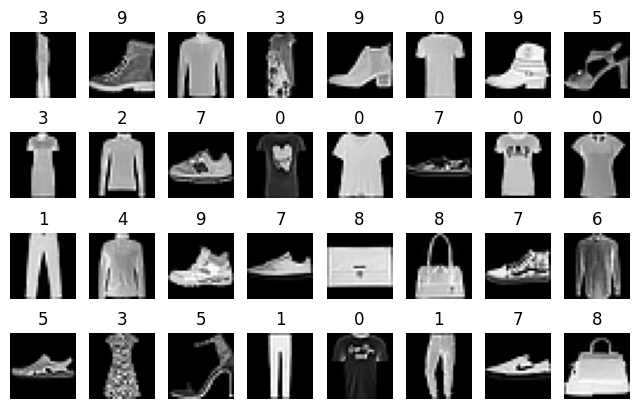

In [520]:
plt.figure(figsize=(8, 5))
for i in range(32):
    index = np.random.randint(0, dataset_len_train)
    plt.subplot(4, 8, i + 1)
    plt.axis(False)
    plt.imshow(X_train[index].reshape((28, 28)), cmap="gray")
    plt.title(y_train[index])
plt.show()

-    Normalizing the datasets

In [477]:
norm_train_df = (X_train - np.mean(X_train)) / np.std(X_train)
norm_test_df = (X_test - np.mean(X_test)) / np.std(X_test)

In [478]:
X_train = pd.DataFrame(norm_train_df)
X_test = pd.DataFrame(norm_test_df)
y_train = pd.get_dummies(
    pd.DataFrame(np.array(list(map(str, y_train))), columns=["Target_Img"])
)
y_test = pd.get_dummies(
    pd.DataFrame(np.array(list(map(str, y_test))), columns=["Target_Img"])
)

-   hyperParamter initialization

In [479]:
W1 = np.random.rand(784, 32)
W2 = np.random.rand(32, 10)
B1 = np.random.rand(1, 32)
B2 = np.random.rand(1, 10)
learning_rate = 0.01
randomization = 10
losses = []
validation_losses = []
iteration = 0
loss_threshold = 0.24
epochs = 0
stored = True
flag = True

In [480]:
X = X_train
y = y_train

-   Traning loop

In [481]:
while epochs <= 5:
    if stored:
        break

    if epochs % randomization == 0:
        # Splitting the data
        X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2)
        y_train = pd.get_dummies(y_train)
        y_validate = pd.get_dummies(y_validate)
        # Creating the batches
        batches_X_train = []
        batches_y_train = []
        j = 0
        for i in range(1875):
            batches_X_train.append(np.array(X_train[j : j + 32]))
            batches_y_train.append(np.array(y_train[j : j + 32]))
            j = j + 32

    for i in range(len(batches_X_train)):
        result = linear_reg_with_NN(
            tanh_activation,
            softmax_cross_entropy,
            x=batches_X_train[i],  # the batches of images with batch size of 32
            w1=W1,
            w2=W2,
            b1=B1,
            b2=B2,
            y=batches_y_train[i],
        )

        y_pred_custom = result["y_pred"]

        loss = result["loss"]

        shape_of_xw1 = result["shape_of_xw1"]

        shape_of_x2w2 = result["shape_of_x2w2"]

        x1w1B1 = result["x1w1B1"]

        iteration += 1

        losses.append(loss)

        if loss <= loss_threshold and validation_loss <= loss_threshold:

            final_Weights = {"W1": W1, "W2": W2}

            final_bias = {"B1": B1, "B2": B2}

            print(
                f"values of Weigths : {final_Weights} and biases : {final_bias} and loss : {loss}"
            )
            flag = False
            break

        derivates = derivatives(
            x1=batches_X_train[i],  # the batches of images with batch size of 32
            x2=x1w1B1,
            w2=W2,
            tanh_activation=tanh_activation,
            shape_of_xw1=shape_of_xw1,
            shape_of_x2w2=shape_of_x2w2,
            y_pred=y_pred_custom,
            y=batches_y_train[i],
        )

        W1 -= learning_rate * (derivates["dL_dW1"])

        B1 -= learning_rate * (derivates["dL_dB1"])

        W2 -= learning_rate * (derivates["dL_dW2"])

        B2 -= learning_rate * (derivates["dL_dB2"])

        # Validation
        validation = linear_reg_with_NN(
            tanh_activation,
            softmax_cross_entropy,
            x=X_validate,
            w1=W1,
            w2=W2,
            b1=B1,
            b2=B2,
            y=y_validate,
        )
        validation_loss = validation["loss"]
        validation_losses.append(validation_loss)

        if iteration % 100 == 0:

            print(
                f"Traning loss is {loss}, validation loss is {validation_loss} and the learning rate is {learning_rate}"
            )

    epochs += 1
    if epochs % 2 == 0 and learning_rate != 0.00001:
        learning_rate *= 0.1

    # if epochs % 100 == 0:
    #     learning_rate /= 0.1

if not stored:
    plt.plot(losses)
    plt.plot(validation_losses)

    plt.legend(["Losses", "validation lossess"])

    plt.show()

- Saving the state dict of the model

In [482]:
import json

file_path = "model/state_dict_mnist_fashion_classification_with_batches.json"
if not stored:
    state_dict = {
        "Weights": {
            "w1": final_Weights["W1"].tolist(),
            "w2": final_Weights["W2"].tolist(),
        },
        "Biases": {"b1": final_bias["B1"].tolist(), "b2": final_bias["B2"].tolist()},
    }

    with open(file_path, "w") as json_file:
        json.dump(state_dict, json_file, indent=6)

In [483]:
with open(file_path, "r") as json_file_read:
    hyper_parameters = json.load(json_file_read)

- Testing loop

In [ ]:
y_test = pd.get_dummies(y_test)
y_pred = linear_reg_with_NN(
    tanh_activation,
    softmax_cross_entropy,
    x=X_test,
    w1=convert_to_np_array(hyper_parameters["Weights"]["w1"]),
    w2=convert_to_np_array(hyper_parameters["Weights"]["w2"]),
    b1=convert_to_np_array(hyper_parameters["Biases"]["b1"]),
    b2=convert_to_np_array(hyper_parameters["Biases"]["b2"]),
    y=y_test,
)
y_pred

In [ ]:
len(y_test)

In [ ]:
final_result = np.sum(y_test == y_pred["y_pred"], axis=1) == 10
final_result = np.sum(final_result)
final_result

In [ ]:
(final_result / len(y_test)) * 100

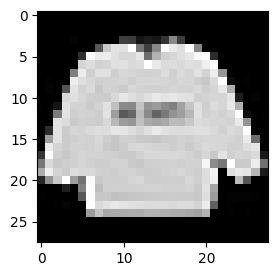

In [558]:
img = X_train[0]
img = img.reshape((28, 28))
plt.figure(figsize=(3,3))
plt.imshow(img, cmap="gray")
plt.show()

In [559]:
kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
kernel

array([[-1, -1, -1],
       [-1,  8, -1],
       [-1, -1, -1]])

-   convolving the image

In [560]:
img_copy = img.copy()
for _ in range(4):
    new_size = (
        img_copy.shape[0] - kernel.shape[0] + 1,
        img_copy.shape[1] - kernel.shape[1] + 1,
    )
    new_image = np.zeros(new_size)
    for i in range(new_size[0]):
        for j in range(new_size[1]):
            new_image[i, j] = np.sum(
                img_copy[i : i + kernel.shape[0], j : j + kernel.shape[1]] * kernel
            )
    img_copy = new_image

In [561]:
img_copy

array([[ 6.40380e+04, -1.99630e+05, -4.16303e+05, -2.92250e+05,
         4.73924e+05,  5.23161e+05,  3.88859e+05,  5.91599e+05,
         5.81960e+04, -2.96800e+03,  3.40915e+05,  5.40215e+05,
         3.17672e+05,  2.41568e+05,  6.96844e+05, -1.21170e+04,
        -4.24000e+05, -1.08785e+05,  8.37460e+04,  7.94000e+03],
       [-3.74150e+04, -1.28318e+05,  7.14688e+05,  1.63839e+05,
        -1.95600e+03, -3.20700e+05, -4.13426e+05, -3.05764e+05,
         1.30758e+05, -5.14320e+05, -1.88528e+05, -3.50102e+05,
        -3.18872e+05, -3.09584e+05, -1.80914e+05,  5.84390e+04,
         5.24389e+05, -1.82610e+05, -1.00636e+05,  1.63941e+05],
       [-3.88977e+05,  2.94448e+05, -2.41494e+05, -3.41281e+05,
        -7.33590e+04,  8.83020e+04,  1.98232e+05,  1.37400e+04,
         1.39111e+05,  3.25084e+05,  3.01269e+05,  1.31503e+05,
         1.55253e+05,  1.14741e+05,  9.58900e+03, -2.14055e+05,
        -1.89215e+05,  5.06090e+05, -4.44874e+05,  6.92890e+04],
       [ 5.94110e+04,  1.38192e+05, -

In [562]:
img_copy.shape

(20, 20)

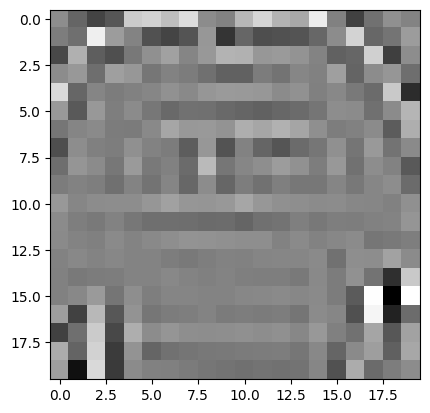

In [563]:
plt.imshow(img_copy, cmap="gray")
plt.show()